In [1]:
import os
import pandas as pd
from MulticoreTSNE import MulticoreTSNE as TSNE
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!mkdir -p sandbox_am #let's put all stuff in the sandbox
os.chdir("sandbox_am")

### Download a sample of ActinoMock Nanopore data

Download the sample file as stated in [https://github.com/Lizhen0909/pyLSHVec](https://github.com/Lizhen0909/pyLSHVec). Here use wget to download it or just download it manually

In [3]:
if not os.path.exists('ActinoMock_Nanopore.seq.gz'):
    !wget http://ww2.cs.fsu.edu/~lshi/ActinoMock_Nanopore.seq.gz

--2021-07-29 07:39:42--  http://ww2.cs.fsu.edu/~lshi/ActinoMock_Nanopore.seq.gz
Resolving ww2.cs.fsu.edu (ww2.cs.fsu.edu)... 128.186.122.20
Connecting to ww2.cs.fsu.edu (ww2.cs.fsu.edu)|128.186.122.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480042209 (458M) [application/x-gzip]
Saving to: 'ActinoMock_Nanopore.seq.gz'

100%[======================================>] 480,042,209 44.9MB/s   in 12s    

2021-07-29 07:39:54 (37.4 MB/s) - 'ActinoMock_Nanopore.seq.gz' saved [480042209/480042209]



In [4]:
!cat ActinoMock_Nanopore.seq.gz | gunzip > data.seq

In [5]:
#only keep sequence data in a file. (other format supported: fasta and fastq)
!cat data.seq | awk -F"\t" '{print $3}' > seq.txt

In [3]:
#put the executables in path
os.environ['PATH'] = os.path.join(os.environ['HOME'], 'mydev', 'lshvec-upcxx','build') + ":" + os.environ['PATH']

### create a hash function

In [10]:
# we could create hash function on the whole data
# However if the whole data is big, it is better to sample a small part from it.
! shuf seq.txt | head -n 1000 > seq.sample.txt

shuf: write error: Broken pipe
shuf: write error


In [11]:
!wc -l seq.sample.txt

1000 seq.sample.txt


In [17]:
!cat /proc/cpuinfo| grep ^process | tail -n 1

processor	: 31


In [24]:
%%time 
!rphash -k 15 --hash-size 25 --thread 16 -i seq.sample.txt -o rp.bin

[2021-07-29 08:00:45.415] [info] Build hash from seq.sample.txt
[2021-07-29 08:00:45.545] [info] RandProjBuilder: hash_size=25, kmer_size=15, n_thread=16
[2021-07-29 08:00:45.555] [info] CRandProj: hash_size=25, kmer_size=15
CPU times: user 5.24 ms, sys: 11 ms, total: 16.2 ms
Wall time: 278 ms


### train the vectors

In [ ]:
%%time
#change epoch to 1 to save time
!train --output model  --epoch 5 --dim 100 --lr 0.1 --hash-file rp.bin --thread 32 seq.txt

In [6]:
!ls *.bin

model_5.vec.bin  rp.bin


### Now the model is trained.  To visualize it, first get vectors of reads. 

In [31]:
%%time
!transform --vec model_5.vec.bin --hash-file rp.bin --thread 24 -o embed.txt seq.txt

[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: program=transform
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: backend=smp
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: zip_output=0
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: inputpath[0]=seq.txt
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: outputpath=
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: scratch_dir=
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: #procs=24
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: hash_file=rp.bin
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: output_file=embed.txt
[2021-07-29 14:20:58.859] [n0042.lr6 r:0 thr:122942] [info] config: model_path=model_5.vec.bin
[2021-07-29 14:20:58.931] [n0042.lr6 r:0 thr:122942] [info] reading vectors from model_5.vec.bin

[2021-07-29 14:23:09.313] [n0042.lr6 r:0 thr:122942] [inf

transform: 33970 32876 32876

transform: 68299 66189 66189

transform: 8403795 82445
[2021-07-29 14:27:35.726] [n0042.lr6 r:0 thr:122942] [info] Finished transforming 84037 sequences
CPU times: user 17.7 s, sys: 3.98 s, total: 21.7 s
Wall time: 6min 43s


### Next get the labels

In [32]:
seqs = pd.read_csv("data.seq",sep='\t', header=None, usecols=[0,1],index_col=0, nrows=20000)
seqs.columns=['id']
seqs['organism']=seqs['id'].map(lambda u: u.split('-')[1])
seqs['class']=seqs['id'].map(lambda u: u.split('-')[2])
seqs['phylum']=seqs['id'].map(lambda u: u.split('-')[3])
seqs.head()

,id,organism,class,phylum
0,,,,
47914,47914-2616644829-Gammaproteobacteria-Proteobac...,2616644829,Gammaproteobacteria,Proteobacteria
78419,78419-2623620618-Gammaproteobacteria-Proteobac...,2623620618,Gammaproteobacteria,Proteobacteria
67045,67045-2623620617-Gammaproteobacteria-Proteobac...,2623620617,Gammaproteobacteria,Proteobacteria
27710,27710-2615840601-Alphaproteobacteria-Proteobac...,2615840601,Alphaproteobacteria,Proteobacteria
31701,31701-2615840697-Gammaproteobacteria-Proteobac...,2615840697,Gammaproteobacteria,Proteobacteria


In [33]:
vec=pd.read_csv('embed.txt', header=None,  nrows=20000, sep=" ").values
vec.shape

(20000, 100)

### Now train TSNE

In [34]:
tsne = TSNE(n_components=2, perplexity=100, n_jobs=8)

In [35]:
%time Y = tsne.fit_transform(vec)

CPU times: user 7min 51s, sys: 5.38 s, total: 7min 56s
Wall time: 1min 1s


### visualization

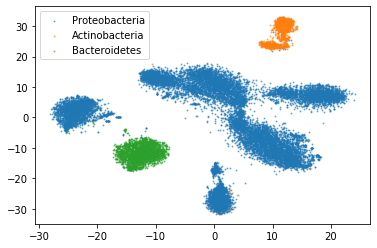

In [39]:
labels=seqs['phylum'].values
legends=list(set(labels))
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)
plt.legend(legends)

['Alphaproteobacteria', 'Gammaproteobacteria', 'Actinobacteria', 'Flavobacteriia']


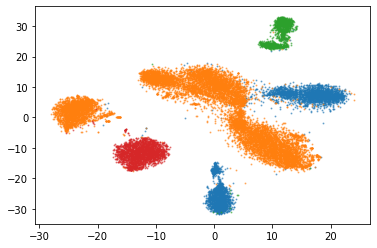

In [37]:
labels=seqs['class'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)

['2616644829', '2615840527', '2623620557', '2617270709', '2623620567', '2615840697', '2623620618', '2615840533', '2615840646', '2623620617', '2615840601']


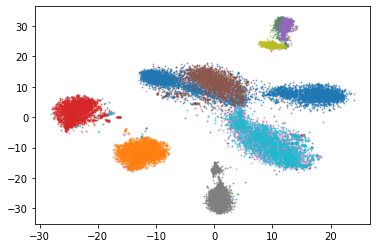

In [38]:
labels=seqs['organism'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)